In [1]:
# does principal component analysis 
# I couldn't find a good package that did what I had expected it to do so I did some investigation and experimentation
    # using a few. This was my favourite

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import statsmodels.multivariate.pca as smp

In [3]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
# ... from wikipedia or something...
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [4]:
def scree(fa):
    eigs = fa.eigenvals
    index = np.arange(len(eigs))+1
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,.85,.8])
    ax.plot(index, eigs, 'bo-')
    ax.set_title('Scree Plot')

In [5]:
indicators = pd.read_csv("1CleansingOutput",encoding = "ISO-8859-1")
indicators.head()

,Unnamed: 0,HHid,Country,Region,Village,Latitude,Longitude,HHsizemembers,HHsizeMAE,HouseholdType,...,Gender_FemaleYouthControl,NFertInput,CropDiv,LivestockDiv,HFIAS_code,Number incomplete,dummy,Income per MAE,Income/MAE decile,Income/MAE for country
0,0,1,Kenya,Wote,175.0,-1.82,37.70,3,2.73,man_single,...,0.000000,0.0,3.0,1.0,2.0,3,NaN,0.000000,0,0.0
1,1,2,Kenya,Wote,175.0,-1.82,37.70,10,6.46,woman_single,...,0.998522,0.0,5.0,3.0,3.0,6,NaN,15.479876,2,1.0
2,2,3,Kenya,Wote,175.0,-1.82,37.71,1,0.73,man_single,...,0.000000,0.0,3.0,2.0,1.0,1,NaN,1861.558219,9,9.0
3,3,4,Kenya,Wote,175.0,-1.82,37.70,4,2.61,woman_single,...,0.999995,0.0,4.0,2.0,3.0,6,NaN,23.712096,2,1.0
4,4,6,Kenya,Wote,175.0,-1.82,37.70,4,3.35,couple,...,0.939961,0.0,6.0,4.0,1.0,1,NaN,101.130597,5,3.0


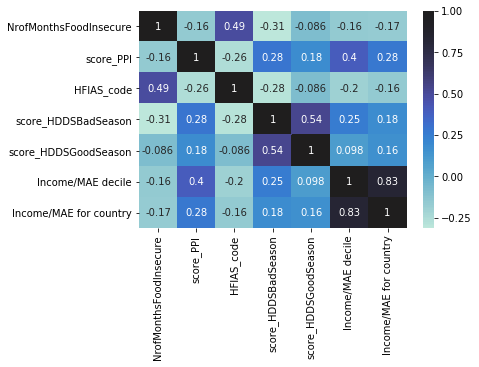

In [6]:
# So return now to look at the indicators of success
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile', 'Income/MAE for country']]
fig = sns.heatmap(indicators_success.corr(method = 'spearman'),annot=True, center=1)
fig.figure.savefig("2PCA success indicators correlations 1.png")

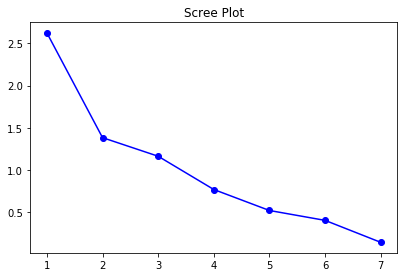

In [7]:
# scree plot - eigenvalues of correlation matrix
p=np.linalg.eig(indicators_success.corr())
index = np.arange(len(p[0]))+1
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,.85,.8])
ax.plot(index, pd.Series(p[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')
fig.savefig("2PCA success indicators scree 1a.png")

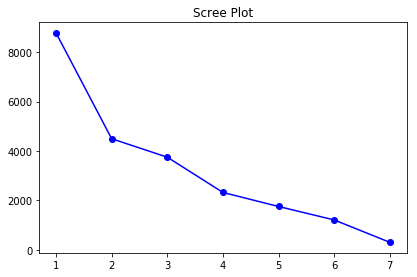

In [8]:
# scree plot of the eigenvalues extracted by the statsmodels PCA
pca = smp.PCA(indicators_success, method = 'nipals', missing='drop-row', ncomp=7)
scree(pca)
fig.savefig("2PCA success indicators scree 1b.png")

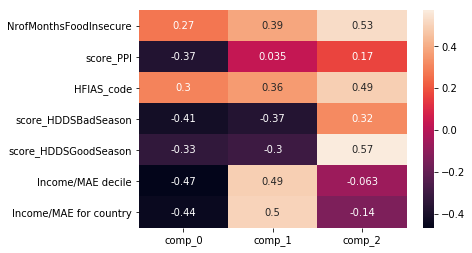

In [9]:
# let's go for 3 factors!
pca = smp.PCA(indicators_success, method = 'nipals', missing='drop-row', ncomp=3)
sns.heatmap(pca.loadings, annot = True)

In [10]:
PCArotated = varimax(pca.loadings)

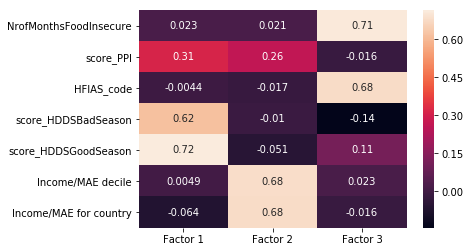

In [11]:
pcaloadings = pd.DataFrame(PCArotated, index=indicators_success.columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
fig = sns.heatmap(pcaloadings, annot=True)
fig.figure.savefig("2PCA success indicators loadings 1.png")

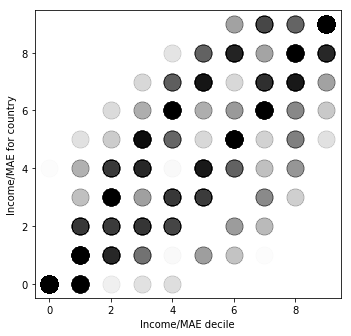

In [12]:
# very neat rotation!
# Factor 1 is HDDS score - quality of diet; PPI contributes to this
# Factor 2 is income - PPI contributes to this; why are both coefficients the same? 
    # They are not the same for the other factors but are highly correlated - consider combining
# Factor 3 is food insecurity and HFIAS code - amount of food. less related to money
fig = plt.figure(figsize = (5,5))
ax = fig.add_axes([0.1,0.1,.85,.8])
plt.scatter(data=indicators, x="Income/MAE decile", y="Income/MAE for country", alpha = 0.01, axes=ax, s = 300, c=(0,0,0))
ax.set_xlabel("Income/MAE decile")
ax.set_ylabel("Income/MAE for country")
fig.savefig('2PCAIncome decile overall by country')
# so they are correlated but not perfectly (Spearman coefficient was 0.83)
# try PCA with only one

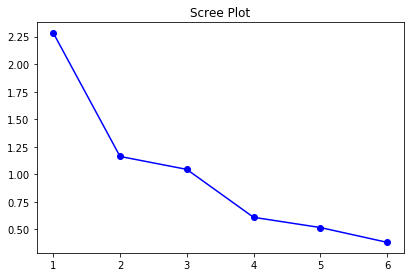

In [13]:
q=np.linalg.eig(indicators_success.iloc[:,:6].corr())
index = np.arange(len(q[0]))+1
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,.85,.8])
ax.plot(index, pd.Series(q[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')
# Again take 3 factors
fig.savefig("2PCA success indicators scree 2a.png")

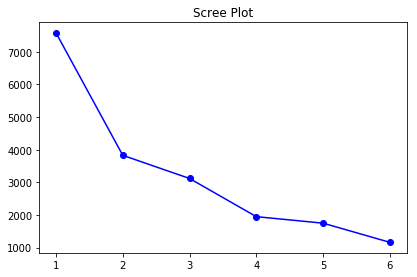

In [14]:
pca2 = smp.PCA(indicators_success.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=6)
scree(pca2)

fig.savefig("2PCA success indicators scree 2b.png")

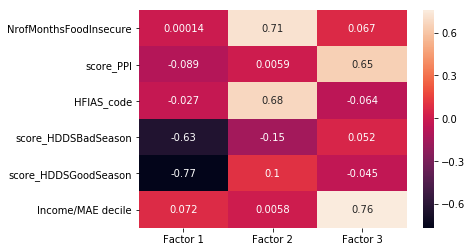

In [15]:
pca2 = smp.PCA(indicators_success.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=3)
PCA2rotated = varimax(pca2.loadings)
pca2loadings = pd.DataFrame(PCA2rotated, index=indicators_success.columns[:6], columns = ['Factor 1', 'Factor 2', 'Factor 3'])
fig = sns.heatmap(pca2loadings, annot=True)
fig.figure.savefig("2PCA success indicators loadings 2")

In [16]:
# How strange - now PPI and income decile load onto the same factor
# Factor 1 - Quality of diet (or lack thereof)
# Factor 2 - Quantity of food
# Factor 3 - Relative income
# I think that this is more helpful

In [17]:
# NEXT STEP - find the missing values, maybe impute, and see what happens

In [18]:
indicators.info()
# Number of months food insecure has a lot of missing values,
# so actually this factor analysis has been performed on only two thirds of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 61 columns):
Unnamed: 0                      5000 non-null int64
HHid                            5000 non-null int64
Country                         5000 non-null object
Region                          4055 non-null object
Village                         4984 non-null float64
Latitude                        4788 non-null float64
Longitude                       4788 non-null float64
HHsizemembers                   5000 non-null int64
HHsizeMAE                       5000 non-null float64
HouseholdType                   4593 non-null object
Head_EducationLevel             4906 non-null object
LandOwned                       4432 non-null float64
LandCultivated                  5000 non-null float64
LivestockHoldings               5000 non-null float64
WorstFoodSecMonth               2379 non-null object
BestFoodSecMonth                2997 non-null object
NrofMonthsFoodInsecure          3764 non-

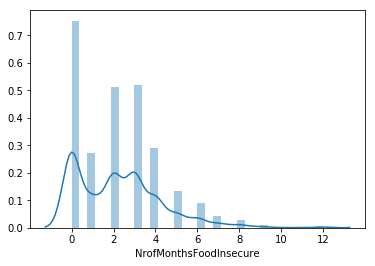

In [19]:
fig = sns.distplot(indicators.NrofMonthsFoodInsecure.dropna())
fig.figure.savefig('2PCA months food insecure distplot')

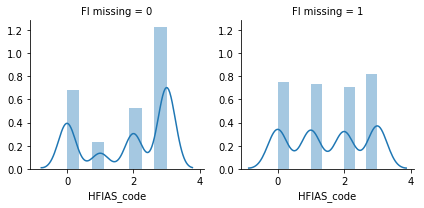

In [20]:
indicators['FI missing']=np.where(pd.isnull(indicators['NrofMonthsFoodInsecure']),1,0)

gr = sns.FacetGrid (indicators, col='FI missing')
gr.map(sns.distplot, 'HFIAS_code')
gr.savefig('2PCA months food insecure by HFIAS')

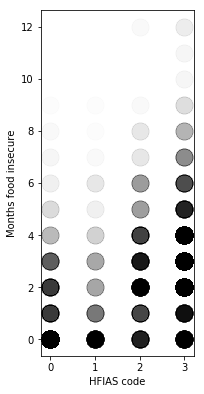

In [21]:
fig = plt.figure(figsize = (2.5,6))
ax = fig.add_axes([0.1,0.1,.85,.8])
plt.scatter(data=indicators, x="HFIAS_code", y="NrofMonthsFoodInsecure", alpha = 0.01, axes=ax, s = 300, c=(0,0,0))
ax.set_xlabel("HFIAS code")
ax.set_ylabel("Months food insecure")
fig.savefig('HFIAS code and months food insecure')

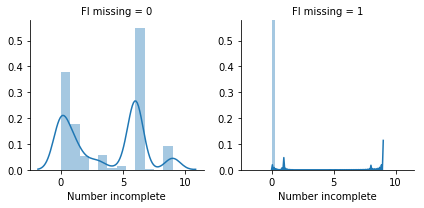

In [22]:
fig = sns.FacetGrid (indicators, col='FI missing').map(sns.distplot, 'Number incomplete')
# ie number of HFIAS questions missing.
# Fortunately the majority of cases with months food insecure missing have answered all HFIAS questions
fig.savefig('2PCA HFIAS questions incomplete against food insecurity incomplete')

In [23]:
# shows that the 'food secure' people need to be taken with a pinch of salt
# for codes 1, 2 and 3 I think we can use this to impute data
# bad season HDDS, PPI and income per MAE decile are also correlated so repeat with those

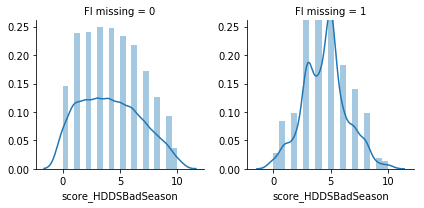

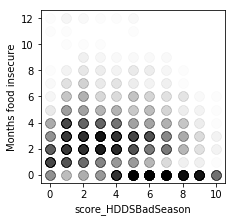

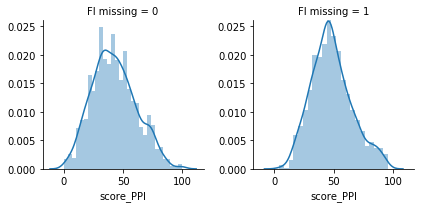

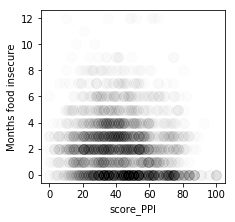

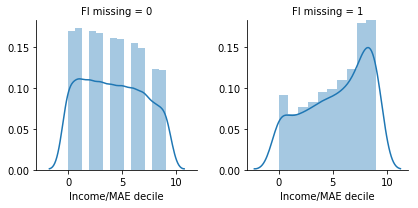

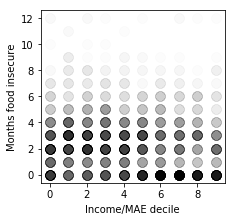

In [24]:
for j in ['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile']:
    fag = sns.FacetGrid (indicators, col='FI missing')
    fag.map(sns.distplot, j)
    fag.savefig('2PCA food insecurity missing vs '+j.replace('/',''))
    
    fig = plt.figure(figsize = (3,3))
    ax = fig.add_axes([0.1,0.1,.85,.8])
    plt.scatter(data=indicators, x=j, y="NrofMonthsFoodInsecure", alpha = 0.01, axes=ax, s = 100, c=(0,0,0))
    ax.set_xlabel(j)
    ax.set_ylabel("Months food insecure")
    fig.savefig('2PCA food insecurity vs'+j.replace('/',''))

In [25]:
# this could be very helpful - combined we can use these measures to impute values.
# where HFIAS code isn't 0 (food secure), I will impute food insecurity from HFIAS code.
# where HIFAS code is 0, notice that months of food insecurity being 0 is closely related 
    # to HDDS bad season score, and also to income decile.
# Plan: impute food insecurity as HFIAS code median where HFIAS code is 1, 2 or 3;
      # use linear regression or decision tree to impute food insecurity from HDDS bad season and MAE decile;
      # have another look at how HFIAS code of 0 compares with these measures (on the imputed and not imputed data)

In [26]:
# impute food insecurity as HFIAS code median where HFIAS code is 1, 2 or 3
# Looks like there is little difference between the median and the mean.
# In fact perhaps the mean is more helpful because the cases which have been imputed will stand out,
# as they are not at whole number points.
print(indicators[['HFIAS_code','FI missing','NrofMonthsFoodInsecure']].groupby(['FI missing','HFIAS_code']).median())
print(indicators[['HFIAS_code','FI missing','NrofMonthsFoodInsecure']].groupby(['FI missing','HFIAS_code']).mean())

                       NrofMonthsFoodInsecure
FI missing HFIAS_code                        
0          0.0                            0.0
           1.0                            0.0
           2.0                            2.0
           3.0                            3.0
1          0.0                            NaN
           1.0                            NaN
           2.0                            NaN
           3.0                            NaN
                       NrofMonthsFoodInsecure
FI missing HFIAS_code                        
0          0.0                       0.798441
           1.0                       1.181818
           2.0                       2.497842
           3.0                       3.003119
1          0.0                            NaN
           1.0                            NaN
           2.0                            NaN
           3.0                            NaN


In [27]:
medians = {0:"HFIAS 0",1:0,2:2,3:3}
means = {0:"HFIAS 0",1:1.181818, 2:2.497842, 3:3.003119}

indicators['FIfromMedian']=np.where(indicators['FI missing']==0,indicators['NrofMonthsFoodInsecure'],
                                    indicators['HFIAS_code'].replace(medians))

indicators['FIfromMean']=np.where(indicators['FI missing']==0,indicators['NrofMonthsFoodInsecure'],
                                    indicators['HFIAS_code'].replace(means))

In [28]:
from sklearn.tree import DecisionTreeRegressor
# this is prone to overfitting, but my predictors are by ranking/codes and PPI is a fixed scale 
# so I'm not worried about extreme values and overfitting

In [29]:
# define X and y
data_to_consider = indicators[indicators['HFIAS_code']==0]
train = data_to_consider[data_to_consider['FI missing']==0]
predict = data_to_consider[data_to_consider['FI missing']==1]
X_tr = train[['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile']]
y_tr = train['NrofMonthsFoodInsecure']
X_pr = predict[['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile']]
# small number of missing values causing problems
for i in X_tr.columns:
    X_tr[i] = np.where(pd.isnull(X_tr[i]),X_tr[i].median(),X_tr[i])
    X_pr[i] = np.where(pd.isnull(X_pr[i]),X_pr[i].median(),X_pr[i])

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [30]:
# the tree is overfitting, I think, from looking at the diagram. Try fewer layers...

dectree = DecisionTreeRegressor(max_leaf_nodes=12, random_state=1).fit(X_tr,y_tr)

In [31]:
predict['imputed FI'] = dectree.predict(X_pr)

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
# insert the predictions into the data frame
mer = predict[['HHid','imputed FI']]
indicators = pd.merge(indicators,mer, on='HHid', how='outer')
indicators['FIfromMedian']=np.where(pd.isnull(indicators['imputed FI']),indicators['FIfromMedian'],indicators['imputed FI'])
indicators['FIfromMean']=np.where(pd.isnull(indicators['imputed FI']),indicators['FIfromMean'],indicators['imputed FI'])

In [33]:
# Now finally check out imputing everything from tree (forget mean and median)
# define X and y
train = indicators[indicators['FI missing']==0]
predict = indicators[indicators['FI missing']==1]
X_tra = train[['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile','HFIAS_code']]
y_tra = train['NrofMonthsFoodInsecure']
X_pra = predict[['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile','HFIAS_code']]
X_tra.info()
# small number of missing values causing problems
for i in X_tra.columns:
    X_tra[i] = np.where(pd.isnull(X_tra[i]),X_tra[i].median(),X_tra[i])
    X_pra[i] = np.where(pd.isnull(X_pra[i]),X_pra[i].median(),X_pra[i])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3764 entries, 0 to 4594
Data columns (total 4 columns):
score_HDDSBadSeason    3759 non-null float64
score_PPI              3243 non-null float64
Income/MAE decile      3764 non-null int64
HFIAS_code             3504 non-null float64
dtypes: float64(3), int64(1)
memory usage: 147.0 KB


C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [34]:
dectreeall = DecisionTreeRegressor(max_leaf_nodes=12, random_state=1).fit(X_tra,y_tra)

In [35]:
predict['imputed FI pure'] = dectreeall.predict(X_pra)

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
predict['imputed FI pure'].describe()

count    1236.000000
mean        1.868864
std         1.052613
min         0.297143
25%         0.831224
50%         2.274725
75%         3.044872
max         3.586614
Name: imputed FI pure, dtype: float64

In [37]:
len(predict['imputed FI pure'].unique())

12

In [38]:
len(predict['imputed FI pure'])

1236

In [39]:
# now merge this into the big dataframe
mer = predict[['HHid','imputed FI pure']]
indicators = pd.merge(indicators,mer, on='HHid', how='outer')
indicators['FI imputed pure']=np.where(pd.isnull(indicators['imputed FI pure']),indicators['NrofMonthsFoodInsecure'],indicators['imputed FI pure'])

In [40]:
# indicators[['FI missing','NrofMonthsFoodInsecure','FI imputed pure','FIfromMedian','FIfromMean']]

# it has worked! I have the 3 imputations ready to do the PCA again.

indicators.to_csv("2PCAOutput")

In [41]:
from sklearn.tree import export_graphviz

In [42]:
export_graphviz(dectree, out_file='treeHFIAS0.dot')
# dectree Xs are [['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile']]
export_graphviz(dectreeall, out_file='treeAnyHFIAS.dot')
# dectree all Xs are [['score_HDDSBadSeason', 'score_PPI', 'Income/MAE decile','HFIAS_code']]
# it didn't use income/mae decile at all, which is interesting because the first did quite a lot

In [43]:
# but it would make so much more sense to impute the missing values using other data from the indicators data

In [44]:
dectree.feature_importances_

array([ 0.18186035,  0.35430785,  0.4638318 ])

In [45]:
dectreeall.feature_importances_

array([ 0.14346126,  0.03854407,  0.        ,  0.81799466])